In [1]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel

# import adapters
# from adapters import AutoAdapterModel
# import gc

import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle
import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
torch.__version__
# transformers.__version__

'2.1.1+cu121'

In [3]:
%load_ext autoreload
%autoreload 2

# from text_embeddings_src.model_stuff import mean_pool
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)

# from text_embeddings_src.embeddings import generate_embeddings
# from text_embeddings_src.metrics import knn_accuracy

# from text_embeddings_src.dim_red import run_tsne_simple
# from text_embeddings_src.plotting import plot_tsne_colors

In [4]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("../../results/variables")
# variables_pubmed_path = Path("../../pubmed-landscape/results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [6]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [7]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [8]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-09-16 13:21:28CEST

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

transformers: 4.43.4

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

memory_profiler    : 0.61.0
torch              : 2.1.1
text_embeddings_src: 0.0.0
pandas             : 2.1.3
distro             : 1.8.0
numpy              : 1.26.2
jupyter_black      : 0.3.4
matplotlib         : 3.8.2
black              : 23.11.0

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import ICLR dataset

In [9]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 296 ms, sys: 108 ms, total: 404 ms
Wall time: 815 ms


In [10]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [11]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [12]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [13]:
# sanity check
print(len(np.unique(labels_iclr)))
labels_iclr

46


array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

# Functions

In [14]:
def fix_all_seeds(seed=42):
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  ## this one is new
    ## Set the seed for generating random numbers on all GPUs.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True) ## this one I don't use but don't remember why

    # Set the random seed for NumPy
    np.random.seed(seed)

    # Set the random seed
    random.seed(seed)

In [15]:
import datasets
from tqdm.notebook import tqdm
from text_embeddings_src.embeddings import mean_pooling, sep_pooling


@torch.no_grad()
def generate_embeddings_embed_layer(
    abstracts, tokenizer, model, device, batch_size=256, return_seventh=False
):
    """Generate embeddings using BERT-based model.

    Parameters
    ----------
    abstracts : list, this has to be a list not sure if array works but pandas do not work
        Abstract texts.
    tokenizer : transformers.models.bert.tokenization_bert_fast.BertTokenizerFast
        Tokenizer.
    model : transformers.models.bert.modeling_bert.BertModel
        BERT-based model.
    device : str, {"cuda", "cpu"}
        "cuda" if torch.cuda.is_available() else "cpu".

    Returns
    -------
    embedding_cls : ndarray
        [CLS] tokens of the abstracts.
    embedding_sep : ndarray
        [SEP] tokens of the abstracts.
    embedding_av : ndarray
        Average of tokens of the abstracts.
    """
    # preprocess the input
    inputs = tokenizer(
        abstracts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512,
    ).to(device)

    dataset = datasets.Dataset.from_dict(inputs)
    dataset.set_format(type="torch", output_all_columns=True)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, num_workers=10
    )

    # new inference
    # model.to(device)

    embedding_av = []
    embedding_sep = []
    embedding_cls = []
    embedding_7th = []

    with torch.no_grad():
        model.eval()
        for batch in tqdm(loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(batch["input_ids"])
            token_embeds = out  # [0]  # get the last hidden state
            av = mean_pooling(token_embeds, batch["attention_mask"])
            sep = sep_pooling(token_embeds, batch["attention_mask"])
            cls = token_embeds[:, 0, :]  # .numpy()
            embedding_av.append(av.detach().cpu().numpy())
            embedding_sep.append(sep.detach().cpu().numpy())
            embedding_cls.append(cls.detach().cpu().numpy())
            if return_seventh == True:
                seventh = token_embeds[:, 7, :]
                embedding_7th.append(seventh.detach().cpu().numpy())

    embedding_av = np.vstack(embedding_av)
    embedding_sep = np.vstack(embedding_sep)
    embedding_cls = np.vstack(embedding_cls)

    if return_seventh == True:
        embedding_7th = np.vstack(embedding_7th)

    return (
        (embedding_cls, embedding_sep, embedding_av, embedding_7th)
        if return_seventh == True
        else (embedding_cls, embedding_sep, embedding_av)
    )

In [16]:
from tqdm.notebook import tqdm
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import (
    mean_pool,
    sep_pool,
    cls_pool,
    seventh_pool,
)
from text_embeddings_src.metrics import knn_accuracy, logistic_accuracy


def train_loop_embedding_layer(
    model,
    loader,
    device,
    titles_abstracts_together,
    tokenizer,
    label_mask,
    labels_acc,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
    eval_metric="knn",
    return_seventh=False,
    return_embeddings=False,
    return_model=False,
):
    assert optimized_rep in [
        "av",
        "cls",
        "sep",
        "7th",
    ], "Not valid `optimized_rep`. Choose from ['av', 'cls', 'sep', '7th']."

    assert eval_metric in [
        "knn",
        "lin",
    ], "Not valid `eval_metric`. Choose from ['knn', 'lin']."

    model.to(device)

    # define layers to be used in multiple-negatives-ranking
    cos_sim = torch.nn.CosineSimilarity()
    loss_func = torch.nn.CrossEntropyLoss()
    scale = 20.0  # we multiply similarity score by this scale value, it is the inverse of the temperature
    # move layers to device
    cos_sim.to(device)
    loss_func.to(device)

    # initialize Adam optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # setup warmup for first ~10% of steps
    total_steps = len(loader) * n_epochs
    warmup_steps = int(0.1 * len(loader))
    scheduler = get_linear_schedule_with_warmup(
        optim,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    losses = np.empty((n_epochs, len(loader)))
    accuracies = []
    for epoch in range(n_epochs):
        model.train()  # make sure model is in training mode
        # initialize the dataloader loop with tqdm (tqdm == progress bar)
        loop = tqdm(loader, leave=True)
        for i_batch, batch in enumerate(loop):
            # zero all gradients on each new step
            optim.zero_grad()
            # prepare batches and move all to the active device
            anchor_ids = batch[0][0].to(
                device
            )  # this are all anchor abstracts from the batch,len(anchor_ids)= len(batch)
            anchor_mask = batch[0][1].to(device)
            pos_ids = batch[1][0].to(
                device
            )  # this each positive pair from each anchor, all in one array, also len(batch)
            pos_mask = batch[1][1].to(device)
            # extract token embeddings from BERT
            a = model(
                anchor_ids
            )  # , attention_mask=anchor_mask)[0]  # all token embeddings
            p = model(pos_ids)  # , attention_mask=pos_mask)[0]

            # get the mean pooled vectors  -- put all of these ifs into a pool function (wraper) to which I pass, a, p the masks and the optimized rep
            if optimized_rep == "av":
                a = mean_pool(a, anchor_mask)
                p = mean_pool(p, pos_mask)

            elif optimized_rep == "cls":
                a = cls_pool(a, anchor_mask)
                p = cls_pool(p, pos_mask)

            elif optimized_rep == "sep":
                a = sep_pool(a, anchor_mask)
                p = sep_pool(p, pos_mask)

            elif optimized_rep == "7th":
                a = seventh_pool(a, anchor_mask)
                p = seventh_pool(p, pos_mask)

            # calculate the cosine similarities
            scores = torch.stack(
                [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
            )
            # get label(s) - we could define this before if confident
            # of consistent batch sizes
            labels = torch.tensor(
                range(len(scores)), dtype=torch.long, device=scores.device
            )  # I think that the labels are just the label of which pair it is. 0 for the first pair, 1 for the second...
            # my guess is that they are used in the loss to know which of the cosine similarities should be high
            # and which low

            # and now calculate the loss
            loss = loss_func(scores * scale, labels)
            losses[epoch, i_batch] = loss.item()

            # using loss, calculate gradients and then optimize
            loss.backward()
            optim.step()
            # update learning rate scheduler
            scheduler.step()
            # update the TDQM progress bar
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(loss=loss.item())

        ## evaluation -- externalize all of these code into an "evaluation" fucntion
        if return_seventh == True:
            (
                embedding_cls,
                embedding_sep,
                embedding_av,
                embedding_7th,
            ) = generate_embeddings_embed_layer(
                titles_abstracts_together,
                tokenizer,
                model,
                device,
                batch_size=256,
                return_seventh=True,
            )
            if eval_metric == "knn":
                acc = knn_accuracy(
                    [
                        embedding_av[label_mask],
                        embedding_cls[label_mask],
                        embedding_sep[label_mask],
                        embedding_7th[label_mask],
                    ],
                    labels_acc,
                )
            elif eval_metric == "lin":
                acc = logistic_accuracy(
                    [
                        embedding_av[label_mask],
                        embedding_cls[label_mask],
                        embedding_sep[label_mask],
                        embedding_7th[label_mask],
                    ],
                    labels_acc,
                )

        else:
            (
                embedding_cls,
                embedding_sep,
                embedding_av,
            ) = generate_embeddings_embed_layer(
                titles_abstracts_together,
                tokenizer,
                model,
                device,
                batch_size=256,
            )
            if eval_metric == "knn":
                acc = knn_accuracy(
                    [
                        embedding_av[label_mask],
                        embedding_cls[label_mask],
                        embedding_sep[label_mask],
                    ],
                    labels_acc,
                )
            elif eval_metric == "lin":
                acc = logistic_accuracy(
                    [
                        embedding_av[label_mask],
                        embedding_cls[label_mask],
                        embedding_sep[label_mask],
                    ],
                    labels_acc,
                )

        accuracies.append(acc)

    # returns
    if return_embeddings == True:
        if return_seventh == True:
            return (
                losses,
                accuracies,
                embedding_cls,
                embedding_sep,
                embedding_av,
                embedding_7th,
            )
        if return_seventh == False:
            return (
                losses,
                accuracies,
                embedding_cls,
                embedding_sep,
                embedding_av,
            )
    elif return_model == True:
        return losses, accuracies, model
    else:
        return losses, accuracies

# Training for my data

Standard training, only embedding layer

## Pre-trained embedding layer (MPNet)

### Initialize model

In [22]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

#### Test -- embedding layer only

In [ ]:
# from transformers import AutoModel
# import torch.nn as nn


# Create a new model with only the embedding layer
class EmbeddingOnlyModel(torch.nn.Module):
    def __init__(self, embedding_layer):
        super().__init__()
        self.embeddings = embedding_layer

    def forward(self, input_ids):
        return self.embeddings(input_ids)

In [37]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings.word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 1.73 s, sys: 1.4 s, total: 3.14 s
Wall time: 1.24 s


In [38]:
pretrained_model.embeddings

MPNetEmbeddings(
  (word_embeddings): Embedding(30527, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
embedding_only_model.to(device)

EmbeddingOnlyModel(
  (embeddings): Embedding(30527, 768, padding_idx=1)
)

In [30]:
dummy_corpus = [
    "The sun is shining brightly in the clear blue sky.",
    "The sun is shining brightly in the clear blue sky.",
    "She made a delicious chocolate cake for dessert.",
    "They are planning a trip to Paris next summer.",
    # "The soccer team won the championship game yesterday.",
    # "He bought a new smartphone with a high-resolution camera.",
]

In [31]:
# preprocess the input
inputs = tokenizer(
    dummy_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)


out = embedding_only_model(inputs.input_ids)  # (**inputs)
token_embeds = out.detach().cpu().numpy()  # not out[0] anymore, but out

In [34]:
inputs

{'input_ids': tensor([[    0,  2000,  3107,  2007,  9720, 14228,  2003,  2000,  3158,  2634,
          3716,  1016,     2],
        [    0,  2000,  3107,  2007,  9720, 14228,  2003,  2000,  3158,  2634,
          3716,  1016,     2],
        [    0,  2020,  2085,  1041, 12094,  7971,  9854,  2009, 18068,  1016,
             2,     1,     1],
        [    0,  2031,  2028,  4045,  1041,  4444,  2004,  3004,  2283,  2625,
          1016,     2,     1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], device='cuda:0')}

In [36]:
inputs.input_ids.shape

torch.Size([4, 13])

In [42]:
out.shape

torch.Size([4, 13, 768])

#### Test -- embedding module

In [42]:

class EmbeddingOnlyModelv2(torch.nn.Module):
    def __init__(self, embeddings_module):
        super().__init__()
        self.embeddings = embeddings_module

    def forward(self, input_ids, position_ids=None, inputs_embeds=None):
        return self.embeddings(input_ids, position_ids, inputs_embeds)

In [43]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_module = pretrained_model.embeddings
# new model
embedding_only_model_v2 = EmbeddingOnlyModelv2(embedding_module)

Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 1.75 s, sys: 1.22 s, total: 2.97 s
Wall time: 1.13 s


In [47]:
embedding_only_model_v2

EmbeddingOnlyModelv2(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [44]:
dummy_corpus = [
    "The sun is shining brightly in the clear blue sky.",
    "The sun is shining brightly in the clear blue sky.",
    "She made a delicious chocolate cake for dessert.",
    "They are planning a trip to Paris next summer.",
    # "The soccer team won the championship game yesterday.",
    # "He bought a new smartphone with a high-resolution camera.",
]

In [45]:
# preprocess the input
inputs = tokenizer(
    dummy_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [46]:
inputs

{'input_ids': tensor([[    0,  2000,  3107,  2007,  9720, 14228,  2003,  2000,  3158,  2634,
          3716,  1016,     2],
        [    0,  2000,  3107,  2007,  9720, 14228,  2003,  2000,  3158,  2634,
          3716,  1016,     2],
        [    0,  2020,  2085,  1041, 12094,  7971,  9854,  2009, 18068,  1016,
             2,     1,     1],
        [    0,  2031,  2028,  4045,  1041,  4444,  2004,  3004,  2283,  2625,
          1016,     2,     1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], device='cuda:0')}

In [66]:
embedding_only_model_v2.to(device)
embedding_only_model_v2.eval()

out = embedding_only_model_v2(inputs.input_ids)  # (**inputs)
token_embeds = out.detach().cpu().numpy()  # not out[0] anymore, but out

In [67]:
token_embeds.shape

(4, 13, 768)

In [71]:
out.shape

torch.Size([4, 13, 768])

##### Compare to the guillotine output

In [68]:
pretrained_model.to(device)
pretrained_model.eval()
outputs = pretrained_model(**inputs, output_hidden_states=True)

In [74]:
outputs.hidden_states[0] == out  

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

### Baseline performance
before any training

#### Embedding layer only


In [43]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings.word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 1.82 s, sys: 1.17 s, total: 3 s
Wall time: 1.19 s


In [48]:
embedding_only_model

EmbeddingOnlyModel(
  (embeddings): Embedding(30527, 768, padding_idx=1)
)

In [46]:
# evaluation

embedding_only_model.to(device)
## get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings_embed_layer(
    iclr2024.abstract.to_list(),
    tokenizer,
    embedding_only_model,
    device,
    batch_size=256,
)

## run knn
knn_accuracies_baseline = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)

# # save
# saving_path = Path("embeddings_" + model_name.lower()) / Path(
#     "updated_dataset"
# )
# (variables_path / saving_path).mkdir(exist_ok=True)

# np.save(variables_path / saving_path / "losses_run_simcse_3", losses)
# np.save(
#     variables_path / saving_path / "knn_accuracies_run_simcse_3",
#     knn_accuracies,
# )

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [47]:
knn_accuracies_baseline

array([0.42230769, 0.03      , 0.01076923])

#### Embedding module

In [78]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings
# new model
embedding_only_model = EmbeddingOnlyModelv2(embedding_layer)

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 1.75 s, sys: 1.31 s, total: 3.05 s
Wall time: 1.19 s


In [79]:
embedding_only_model

EmbeddingOnlyModelv2(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [80]:
# evaluation

embedding_only_model.to(device)
## get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings_embed_layer(
    iclr2024.abstract.to_list(),
    tokenizer,
    embedding_only_model,
    device,
    batch_size=256,
)

## run knn
knn_accuracies_baseline = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)

# # save
# saving_path = Path("embeddings_" + model_name.lower()) / Path(
#     "updated_dataset"
# )
# (variables_path / saving_path).mkdir(exist_ok=True)

# np.save(variables_path / saving_path / "losses_run_simcse_3", losses)
# np.save(
#     variables_path / saving_path / "knn_accuracies_run_simcse_3",
#     knn_accuracies,
# )

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [81]:
knn_accuracies_baseline

array([0.49923077, 0.03      , 0.05230769])

### Run 1

In [82]:
class EmbeddingOnlyModel(torch.nn.Module):
    def __init__(self, embeddings_module):
        super().__init__()
        self.embeddings = embeddings_module

    def forward(self, input_ids, position_ids=None, inputs_embeds=None):
        return self.embeddings(input_ids, position_ids, inputs_embeds)

In [83]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings  # .word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 1.77 s, sys: 1.1 s, total: 2.87 s
Wall time: 1.17 s


In [88]:
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
    return_model=False,
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_1",
    knn_accuracies,
)

print("----------------------------")

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------


In [89]:
print(knn_accuracies)

[array([0.50307692, 0.03      , 0.05307692])]


In [ ]:
# embedding layer only
# [array([0.43538462, 0.03      , 0.01076923])]

### Run 2
Same as run 1 but for 10 epochs

In [90]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings  # .word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_2", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_2",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 15min 39s, sys: 6min 33s, total: 22min 13s
Wall time: 4min 23s


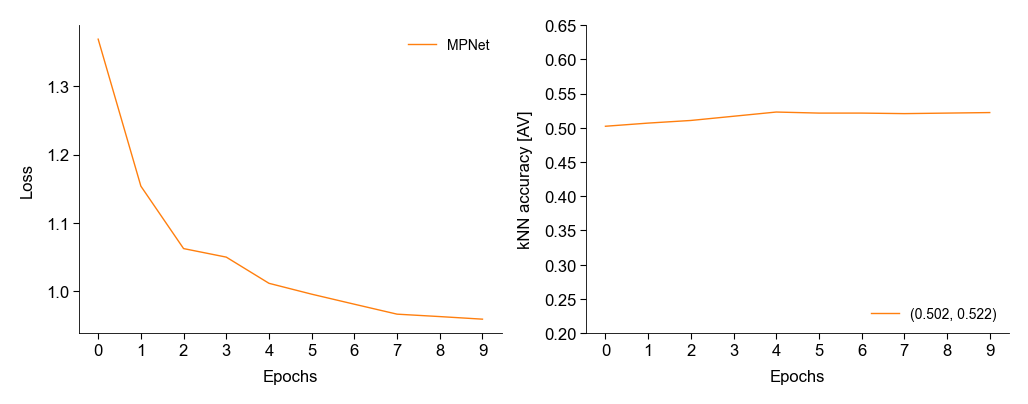

In [91]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/embedding_layer_experiment"
    )
    losses = np.load(variables_path / saving_path / "losses_run_2.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run_2.npy"
    )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    # plot
    color = colormap(1)

    axs[0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0].set_xticks(np.arange(n_epochs))
    # axs[0].set_ylim(top=0.05)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    # axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    # axs[1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    axs[1].set_xticks(np.arange(n_epochs))
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("kNN accuracy [AV]")
    axs[1].legend(loc="lower right")

    # axs[1, 0].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 1],
    #     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    #     color=color,
    # )
    # axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.2, 0.65)
    # axs[1, 0].set_xlabel("Epochs")
    # axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    # axs[1, 0].legend()

    # axs[1, 1].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 2],
    #     label=model_name,
    #     color=color,
    # )
    # axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.2, 0.65)
    # axs[1, 1].set_xlabel("Epochs")
    # axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_run_2_v2.png"
)

### Run 4
Same as run 2 but with lr 2e-4


In [96]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings  # .word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-4,
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_4", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_4",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 15min 11s, sys: 6min 18s, total: 21min 30s
Wall time: 4min 17s


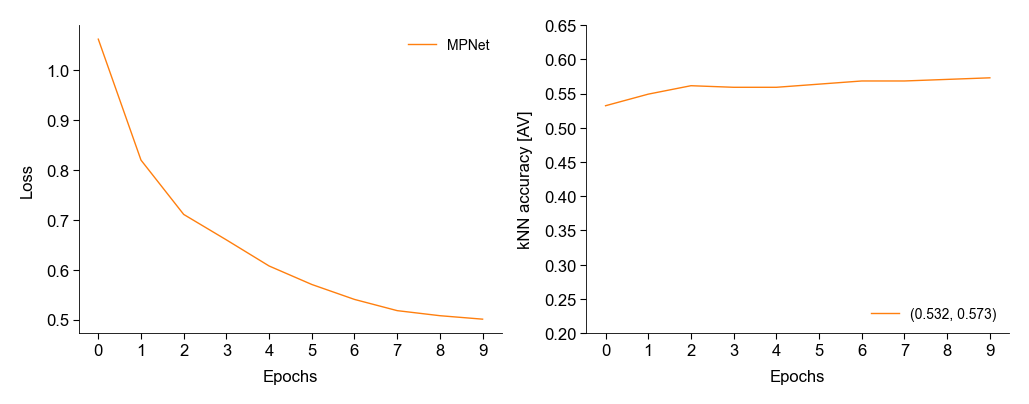

In [98]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/embedding_layer_experiment"
    )
    losses = np.load(variables_path / saving_path / "losses_run_4.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run_4.npy"
    )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    # plot
    color = colormap(1)

    axs[0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0].set_xticks(np.arange(n_epochs))
    # axs[0].set_ylim(top=0.05)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    # axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    # axs[1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    axs[1].set_xticks(np.arange(n_epochs))
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("kNN accuracy [AV]")
    axs[1].legend(loc="lower right")

    # axs[1, 0].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 1],
    #     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    #     color=color,
    # )
    # axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.2, 0.65)
    # axs[1, 0].set_xlabel("Epochs")
    # axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    # axs[1, 0].legend()

    # axs[1, 1].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 2],
    #     label=model_name,
    #     color=color,
    # )
    # axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.2, 0.65)
    # axs[1, 1].set_xlabel("Epochs")
    # axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_run_4_v1.png"
)

### Run 5
Same as run 2 but with lr 2e-3


In [99]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings  # .word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-3,
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_5", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_5",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 14min 59s, sys: 6min 19s, total: 21min 19s
Wall time: 4min 21s


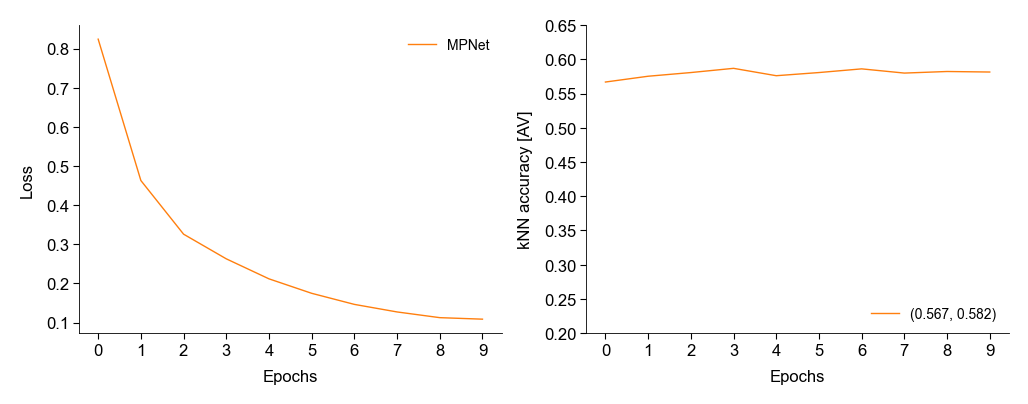

In [100]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/embedding_layer_experiment"
    )
    losses = np.load(variables_path / saving_path / "losses_run_5.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run_5.npy"
    )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    # plot
    color = colormap(1)

    axs[0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0].set_xticks(np.arange(n_epochs))
    # axs[0].set_ylim(top=0.05)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    # axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    # axs[1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    axs[1].set_xticks(np.arange(n_epochs))
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("kNN accuracy [AV]")
    axs[1].legend(loc="lower right")

    # axs[1, 0].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 1],
    #     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    #     color=color,
    # )
    # axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.2, 0.65)
    # axs[1, 0].set_xlabel("Epochs")
    # axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    # axs[1, 0].legend()

    # axs[1, 1].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 2],
    #     label=model_name,
    #     color=color,
    # )
    # axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.2, 0.65)
    # axs[1, 1].set_xlabel("Epochs")
    # axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_run_5_v1.png"
)

### Run 6
Same as run 2 but with lr 5e-2


In [104]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings  # .word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-2,
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_6", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_6",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 15min, sys: 6min 29s, total: 21min 30s
Wall time: 4min 23s


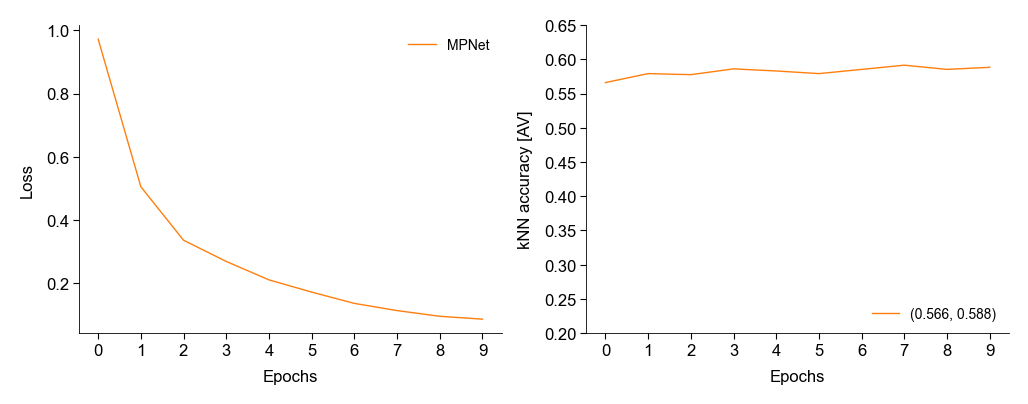

In [109]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/embedding_layer_experiment"
    )
    losses = np.load(variables_path / saving_path / "losses_run_6.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run_6.npy"
    )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    # plot
    color = colormap(1)

    axs[0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0].set_xticks(np.arange(n_epochs))
    # axs[0].set_ylim(top=0.05)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    # axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    # axs[1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    axs[1].set_xticks(np.arange(n_epochs))
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("kNN accuracy [AV]")
    axs[1].legend(loc="lower right")

    # axs[1, 0].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 1],
    #     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    #     color=color,
    # )
    # axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.2, 0.65)
    # axs[1, 0].set_xlabel("Epochs")
    # axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    # axs[1, 0].legend()

    # axs[1, 1].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 2],
    #     label=model_name,
    #     color=color,
    # )
    # axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.2, 0.65)
    # axs[1, 1].set_xlabel("Epochs")
    # axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_run_6_v1.png"
)

### Run 7
Same as run 2 but with lr 1e-2


In [111]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings  # .word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=1e-2,
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_7", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_7",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 17min 23s, sys: 5min 56s, total: 23min 20s
Wall time: 4min 22s


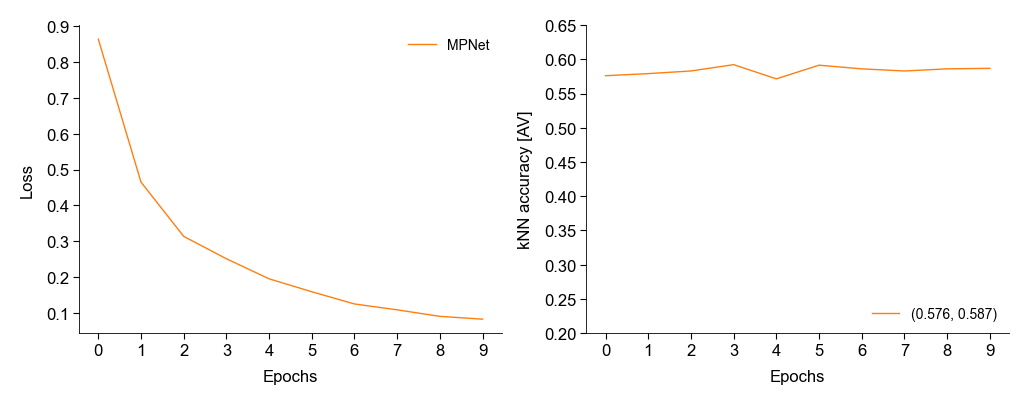

In [113]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/embedding_layer_experiment"
    )
    losses = np.load(variables_path / saving_path / "losses_run_7.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run_7.npy"
    )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    # plot
    color = colormap(1)

    axs[0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0].set_xticks(np.arange(n_epochs))
    # axs[0].set_ylim(top=0.05)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    # axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    # axs[1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    axs[1].set_xticks(np.arange(n_epochs))
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("kNN accuracy [AV]")
    axs[1].legend(loc="lower right")

    # axs[1, 0].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 1],
    #     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    #     color=color,
    # )
    # axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.2, 0.65)
    # axs[1, 0].set_xlabel("Epochs")
    # axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    # axs[1, 0].legend()

    # axs[1, 1].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 2],
    #     label=model_name,
    #     color=color,
    # )
    # axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.2, 0.65)
    # axs[1, 1].set_xlabel("Epochs")
    # axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_run_7_v1.png"
)

### Run 8 -- best
Same as run 2 but with lr 


In [130]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings  # .word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_8", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_8",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 15min 26s, sys: 6min 27s, total: 21min 53s
Wall time: 4min 17s


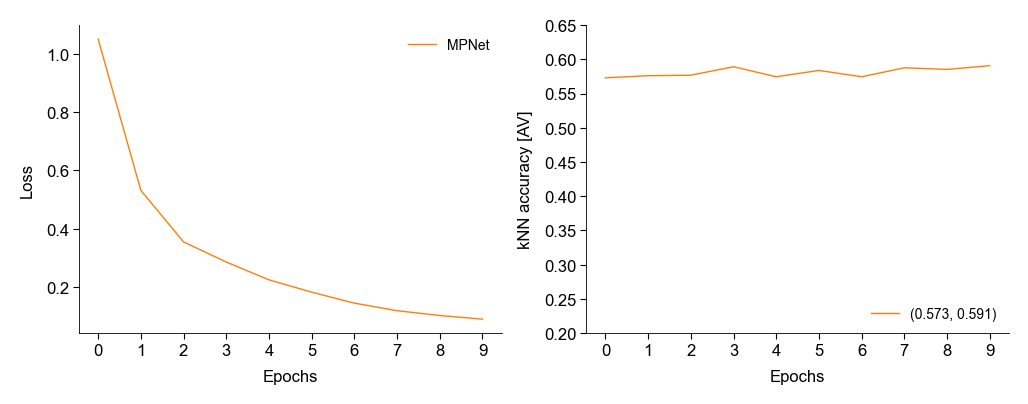

In [133]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/embedding_layer_experiment"
    )
    losses = np.load(variables_path / saving_path / "losses_run_8.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run_8.npy"
    )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    # plot
    color = colormap(1)

    axs[0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0].set_xticks(np.arange(n_epochs))
    # axs[0].set_ylim(top=0.05)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    # axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    # axs[1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    axs[1].set_xticks(np.arange(n_epochs))
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("kNN accuracy [AV]")
    axs[1].legend(loc="lower right")

    # axs[1, 0].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 1],
    #     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    #     color=color,
    # )
    # axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.2, 0.65)
    # axs[1, 0].set_xlabel("Epochs")
    # axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    # axs[1, 0].legend()

    # axs[1, 1].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 2],
    #     label=model_name,
    #     color=color,
    # )
    # axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.2, 0.65)
    # axs[1, 1].set_xlabel("Epochs")
    # axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_run_8_v1.png"
)

In [134]:
knn_accuracies[:, 0]

array([0.57307692, 0.57615385, 0.57692308, 0.58923077, 0.57461538,
       0.58384615, 0.57461538, 0.58769231, 0.58538462, 0.59076923])

### Run 9
Same as run 2 but with lr 


In [128]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings  # .word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=2,
    lr=10,
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_9", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_9",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 4min 15s, sys: 1min 53s, total: 6min 9s
Wall time: 1min 5s


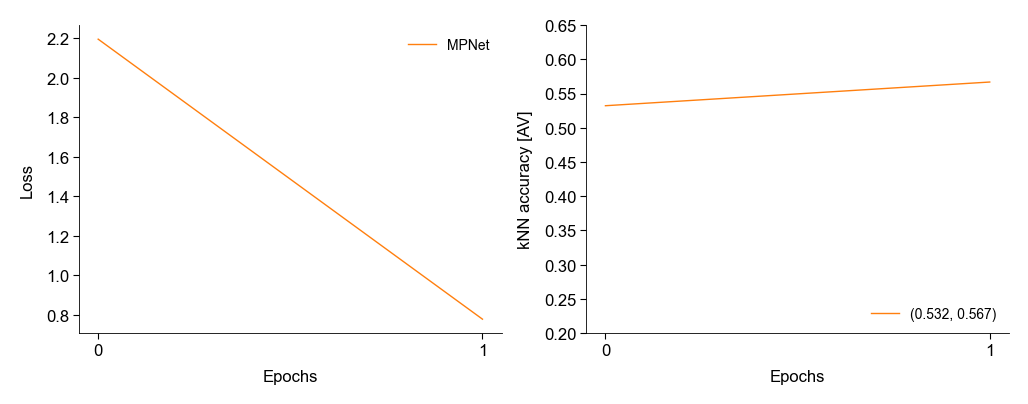

In [129]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 2
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/embedding_layer_experiment"
    )
    losses = np.load(variables_path / saving_path / "losses_run_9.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run_9.npy"
    )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    # plot
    color = colormap(1)

    axs[0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0].set_xticks(np.arange(n_epochs))
    # axs[0].set_ylim(top=0.05)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    # axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    # axs[1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    axs[1].set_xticks(np.arange(n_epochs))
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("kNN accuracy [AV]")
    axs[1].legend(loc="lower right")

    # axs[1, 0].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 1],
    #     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    #     color=color,
    # )
    # axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.2, 0.65)
    # axs[1, 0].set_xlabel("Epochs")
    # axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    # axs[1, 0].legend()

    # axs[1, 1].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 2],
    #     label=model_name,
    #     color=color,
    # )
    # axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.2, 0.65)
    # axs[1, 1].set_xlabel("Epochs")
    # axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_run_9_v1.png"
)

### Run 10 
Same as run 8 but with embedding layer only model, not module

Conclussion: the improvement is not due to the whole embedding module, but due to the change in learning rate.


In [46]:
labels_iclr

array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

In [45]:
# from transformers import AutoModel
# import torch.nn as nn


# Create a new model with only the embedding layer
class EmbeddingOnlyModel(torch.nn.Module):
    def __init__(self, embedding_layer):
        super().__init__()
        self.embeddings = embedding_layer

    def forward(self, input_ids):
        return self.embeddings(input_ids)

In [47]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings.word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_10", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_10",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 16min 55s, sys: 6min 10s, total: 23min 6s
Wall time: 4min 2s


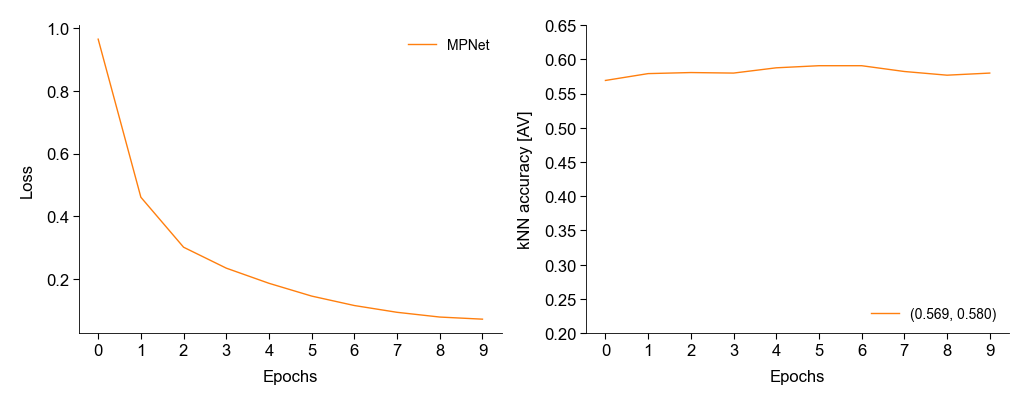

In [48]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/embedding_layer_experiment"
    )
    losses = np.load(variables_path / saving_path / "losses_run_10.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run_10.npy"
    )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    # plot
    color = colormap(1)

    axs[0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0].set_xticks(np.arange(n_epochs))
    # axs[0].set_ylim(top=0.05)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    # axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    # axs[1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    axs[1].set_xticks(np.arange(n_epochs))
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("kNN accuracy [AV]")
    axs[1].legend(loc="lower right")

    # axs[1, 0].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 1],
    #     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    #     color=color,
    # )
    # axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.2, 0.65)
    # axs[1, 0].set_xlabel("Epochs")
    # axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    # axs[1, 0].legend()

    # axs[1, 1].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 2],
    #     label=model_name,
    #     color=color,
    # )
    # axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.2, 0.65)
    # axs[1, 1].set_xlabel("Epochs")
    # axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_run_10_v1.png"
)

### Run 3 -- didn't rerun yet

In [92]:
from tqdm.notebook import tqdm
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import (
    mean_pool,
    sep_pool,
    cls_pool,
    seventh_pool,
)
from text_embeddings_src.metrics import knn_accuracy, logistic_accuracy


def train_loop_without_eval(
    model,
    loader,
    device,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
):
    assert optimized_rep in [
        "av",
        "cls",
        "sep",
        "7th",
    ], "Not valid `optimized_rep`. Choose from ['av', 'cls', 'sep', '7th']."

    model.to(device)

    # define layers to be used in multiple-negatives-ranking
    cos_sim = torch.nn.CosineSimilarity()
    loss_func = torch.nn.CrossEntropyLoss()
    scale = 20.0  # we multiply similarity score by this scale value, it is the inverse of the temperature
    # move layers to device
    cos_sim.to(device)
    loss_func.to(device)

    # initialize Adam optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # setup warmup for first ~10% of steps
    total_steps = len(loader) * n_epochs
    warmup_steps = int(0.1 * len(loader))
    scheduler = get_linear_schedule_with_warmup(
        optim,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    losses = np.empty((n_epochs, len(loader)))
    accuracies = []
    for epoch in range(n_epochs):
        model.train()  # make sure model is in training mode
        # initialize the dataloader loop with tqdm (tqdm == progress bar)
        loop = tqdm(loader, leave=True)
        for i_batch, batch in enumerate(loop):
            # zero all gradients on each new step
            optim.zero_grad()
            # prepare batches and move all to the active device
            anchor_ids = batch[0][0].to(
                device
            )  # this are all anchor abstracts from the batch,len(anchor_ids)= len(batch)
            anchor_mask = batch[0][1].to(device)
            pos_ids = batch[1][0].to(
                device
            )  # this each positive pair from each anchor, all in one array, also len(batch)
            pos_mask = batch[1][1].to(device)
            # extract token embeddings from BERT
            a = model(anchor_ids)  # , attention_mask=anchor_mask)[
            #     0
            # ]  # all token embeddings
            p = model(pos_ids)  # , attention_mask=pos_mask)[0]

            # get the mean pooled vectors  -- put all of these ifs into a pool function (wraper) to which I pass, a, p the masks and the optimized rep
            if optimized_rep == "av":
                a = mean_pool(a, anchor_mask)
                p = mean_pool(p, pos_mask)

            elif optimized_rep == "cls":
                a = cls_pool(a, anchor_mask)
                p = cls_pool(p, pos_mask)

            elif optimized_rep == "sep":
                a = sep_pool(a, anchor_mask)
                p = sep_pool(p, pos_mask)

            elif optimized_rep == "7th":
                a = seventh_pool(a, anchor_mask)
                p = seventh_pool(p, pos_mask)

            # calculate the cosine similarities
            scores = torch.stack(
                [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
            )
            # get label(s) - we could define this before if confident
            # of consistent batch sizes
            labels = torch.tensor(
                range(len(scores)), dtype=torch.long, device=scores.device
            )  # I think that the labels are just the label of which pair it is. 0 for the first pair, 1 for the second...
            # my guess is that they are used in the loss to know which of the cosine similarities should be high
            # and which low

            # and now calculate the loss
            loss = loss_func(scores * scale, labels)
            losses[epoch, i_batch] = loss.item()

            # using loss, calculate gradients and then optimize
            loss.backward()
            optim.step()
            # update learning rate scheduler
            scheduler.step()
            # update the TDQM progress bar
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(loss=loss.item())

    return model, losses

In [93]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [94]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings  # .word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
model_trained, losses = train_loop_without_eval(
    embedding_only_model,
    training_loader,
    device,
    optimized_rep="av",
    n_epochs=20,
    lr=2e-5,
)

# evaluation
## get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings_embed_layer(
    iclr2024.abstract.to_list(),
    tokenizer,
    model_trained,
    device,
    batch_size=256,
)

## run knn
knn_accuracies = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_3",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 7min 6s, sys: 1min 52s, total: 8min 58s
Wall time: 4min 49s


In [95]:
print(knn_accuracies)

[0.53384615 0.03       0.05384615]


In [ ]:
# embedding layer only
# [0.44076923 0.03       0.01076923]

[0.44076923 0.03       0.01076923]


In [32]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
## model
# Load the pretrained model
pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = pretrained_model.embeddings.word_embeddings
# new model
embedding_only_model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
model_trained, losses = train_loop_without_eval(
    embedding_only_model,
    training_loader,
    device,
    optimized_rep="av",
    n_epochs=50,
    lr=2e-5,
)

# evaluation
## get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings_embed_layer(
    iclr2024.abstract.to_list(),
    tokenizer,
    model_trained,
    device,
    batch_size=256,
)

## run knn
knn_accuracies = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)

# save
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_4", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_4",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 12min 3s, sys: 2min 43s, total: 14min 47s
Wall time: 10min 45s


In [34]:
knn_accuracies

array([0.53846154, 0.03      , 0.01076923])

In [ ]:
# embedding layer only
# array([0.53846154, 0.03      , 0.01076923])

array([0.53846154, 0.03      , 0.01076923])

In [29]:
saving_path = Path("embeddings_" + model_names[0].lower()) / Path(
    "updated_dataset"
)

# print(
#     np.load(
#         variables_path / saving_path / "knn_accuracies_run_3.npy",
#         allow_pickle=True,
#     )
# )
# print(
np.load(
    variables_path / saving_path / "knn_accuracies_run_3.npy",
    allow_pickle=True,
)

array([0.50307692, 0.03      , 0.01076923])

## Randomly initialized model

### Test class

In [49]:
# #  from the transformers code
# class BertEmbeddings(nn.Module):
#     """Construct the embeddings from word, position and token_type embeddings."""

#     def __init__(self, config):
#         super().__init__()
#         self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
#         self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
#         self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

#         # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
#         # any TensorFlow checkpoint file
#         self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
#         self.dropout = nn.Dropout(config.hidden_dropout_prob)
#         # position_ids (1, len position emb) is contiguous in memory and exported when serialized
#         self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
#         self.register_buffer(
#             "position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)), persistent=False
#         )
#         self.register_buffer(
#             "token_type_ids", torch.zeros(self.position_ids.size(), dtype=torch.long), persistent=False
#         )

#     def forward(
#         self,
#         input_ids: Optional[torch.LongTensor] = None,
#         token_type_ids: Optional[torch.LongTensor] = None,
#         position_ids: Optional[torch.LongTensor] = None,
#         inputs_embeds: Optional[torch.FloatTensor] = None,
#         past_key_values_length: int = 0,
#     ) -> torch.Tensor:
#         if input_ids is not None:
#             input_shape = input_ids.size()
#         else:
#             input_shape = inputs_embeds.size()[:-1]

#         seq_length = input_shape[1]

#         if position_ids is None:
#             position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]

#         # Setting the token_type_ids to the registered buffer in constructor where it is all zeros, which usually occurs
#         # when its auto-generated, registered buffer helps users when tracing the model without passing token_type_ids, solves
#         # issue #5664
#         if token_type_ids is None:
#             if hasattr(self, "token_type_ids"):
#                 buffered_token_type_ids = self.token_type_ids[:, :seq_length]
#                 buffered_token_type_ids_expanded = buffered_token_type_ids.expand(input_shape[0], seq_length)
#                 token_type_ids = buffered_token_type_ids_expanded
#             else:
#                 token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

#         if inputs_embeds is None:
#             inputs_embeds = self.word_embeddings(input_ids)
#         token_type_embeddings = self.token_type_embeddings(token_type_ids)

#         embeddings = inputs_embeds + token_type_embeddings
#         if self.position_embedding_type == "absolute":
#             position_embeddings = self.position_embeddings(position_ids)
#             embeddings += position_embeddings
#         embeddings = self.LayerNorm(embeddings)
#         embeddings = self.dropout(embeddings)
#         return embeddings

### Test model

In [26]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [27]:
model_random

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### Baseline

In [39]:
class EmbeddingOnlyModel(torch.nn.Module):
    def __init__(self, embeddings_module):
        super().__init__()
        self.embeddings = embeddings_module

    def forward(self, input_ids, position_ids=None, inputs_embeds=None):
        return self.embeddings(input_ids, position_ids, inputs_embeds)

In [40]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [41]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
## model
# Load the pretrained model
# pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = model_random.embeddings  # .word_embeddings
# new model
embedding_only_model_random = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 29.2 ms, sys: 9.68 ms, total: 38.9 ms
Wall time: 151 ms


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [43]:
# evaluation

embedding_only_model_random.to(device)
## get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings_embed_layer(
    iclr2024.abstract.to_list(),
    tokenizer,
    embedding_only_model_random,
    device,
    batch_size=256,
)

## run knn
knn_accuracies_baseline = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)

# # save
# saving_path = Path("embeddings_" + model_name.lower()) / Path(
#     "updated_dataset"
# )
# (variables_path / saving_path).mkdir(exist_ok=True)

# np.save(variables_path / saving_path / "losses_run_simcse_3", losses)
# np.save(
#     variables_path / saving_path / "knn_accuracies_run_simcse_3",
#     knn_accuracies,
# )

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [44]:
knn_accuracies_baseline

array([0.39461538, 0.03      , 0.04923077])

### Run 1
Same as run 8 but with the randomly initialized model. That means with a lr=5e-1.


In [ ]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [29]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
## model
# Load the pretrained model
# pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = model_random.embeddings  # .word_embeddings
# new model
embedding_only_model_random = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 39.2 ms, sys: 17.9 ms, total: 57.1 ms
Wall time: 281 ms


In [30]:
embedding_only_model_random

EmbeddingOnlyModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [31]:
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model_random,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_1",
    knn_accuracies,
)

print("----------------------------")

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------


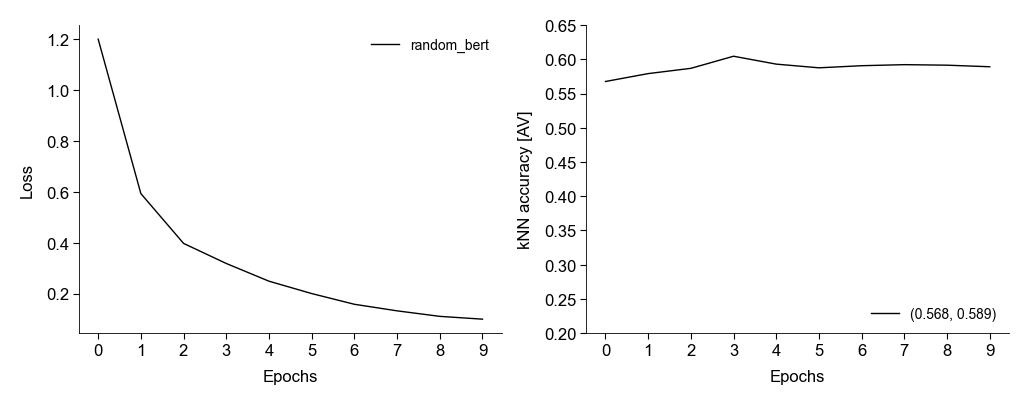

In [35]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")
model_name = "random_bert"

# load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
losses = np.load(variables_path / saving_path / "losses_run_1.npy")
knn_accuracies = np.load(
    variables_path / saving_path / "knn_accuracies_run_1.npy"
)

# saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
# knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

# plot
color = "k"

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label=model_name,
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)
# axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
# axs[1].text(
#     -0.3,
#     knn_acc_highd[0],
#     f"{knn_acc_highd[0]:.3f}",
#     fontsize=5,
#     va="center",
#     ha="left",
# )
axs[1].set_xticks(np.arange(n_epochs))
axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")

# axs[1, 0].plot(
#     np.arange(n_epochs),
#     knn_accuracies[:, 1],
#     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
#     color=color,
# )
# axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
# axs[1, 0].set_xticks(np.arange(n_epochs))
# axs[1, 0].set_ylim(0.2, 0.65)
# axs[1, 0].set_xlabel("Epochs")
# axs[1, 0].set_ylabel("kNN accuracy [CLS]")
# axs[1, 0].legend()

# axs[1, 1].plot(
#     np.arange(n_epochs),
#     knn_accuracies[:, 2],
#     label=model_name,
#     color=color,
# )
# axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
# axs[1, 1].set_xticks(np.arange(n_epochs))
# axs[1, 1].set_ylim(0.2, 0.65)
# axs[1, 1].set_xlabel("Epochs")
# axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_random_run_1_v1.png"
)

### Run 2
Same as run 10 but with random BERT 
embedding layer only model, not module


In [17]:
# Create a new model with only the embedding layer
class EmbeddingOnlyModel(torch.nn.Module):
    # valid function for both the layer and the module (04/09/2024)
    def __init__(self, embedding_layer):
        super().__init__()
        self.embeddings = embedding_layer

    def forward(self, input_ids):
        return self.embeddings(input_ids)

In [18]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [21]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
## model
# Load the pretrained model
# pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_2", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_2",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 15min 21s, sys: 6min 23s, total: 21min 45s
Wall time: 4min 53s


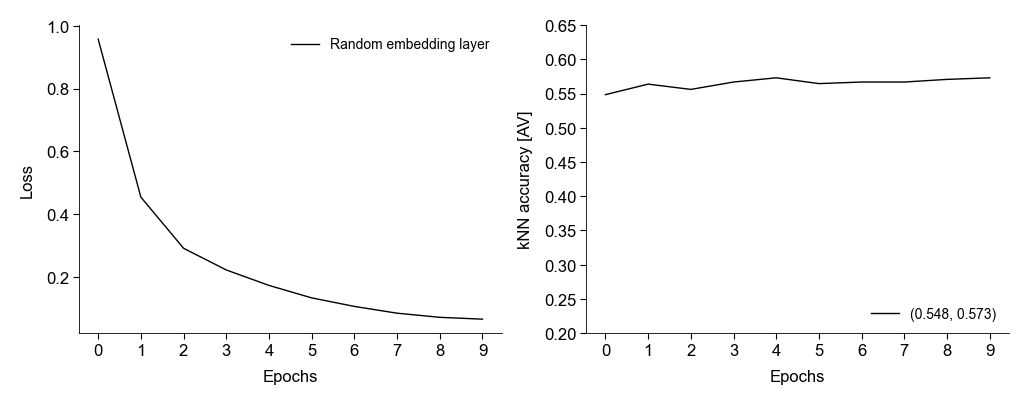

In [23]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")
model_name = "random_bert"


# load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
losses = np.load(variables_path / saving_path / "losses_run_2.npy")
knn_accuracies = np.load(
    variables_path / saving_path / "knn_accuracies_run_2.npy"
)

# saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
# knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

# plot
color = "k"  # colormap(1)

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label="Random embedding layer",
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)
# axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
# axs[1].text(
#     -0.3,
#     knn_acc_highd[0],
#     f"{knn_acc_highd[0]:.3f}",
#     fontsize=5,
#     va="center",
#     ha="left",
# )
axs[1].set_xticks(np.arange(n_epochs))
axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")

# axs[1, 0].plot(
#     np.arange(n_epochs),
#     knn_accuracies[:, 1],
#     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
#     color=color,
# )
# axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
# axs[1, 0].set_xticks(np.arange(n_epochs))
# axs[1, 0].set_ylim(0.2, 0.65)
# axs[1, 0].set_xlabel("Epochs")
# axs[1, 0].set_ylabel("kNN accuracy [CLS]")
# axs[1, 0].legend()

# axs[1, 1].plot(
#     np.arange(n_epochs),
#     knn_accuracies[:, 2],
#     label=model_name,
#     color=color,
# )
# axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
# axs[1, 1].set_xticks(np.arange(n_epochs))
# axs[1, 1].set_ylim(0.2, 0.65)
# axs[1, 1].set_xlabel("Epochs")
# axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_random_run_2_v1.png"
)

### Run 3 
Same as run 2 with random BERT but evaluating knn acc using cosine distances
embedding layer only model, not module


In [17]:
# Create a new model with only the embedding layer
class EmbeddingOnlyModel(torch.nn.Module):
    # valid function for both the layer and the module (04/09/2024)
    def __init__(self, embedding_layer):
        super().__init__()
        self.embeddings = embedding_layer

    def forward(self, input_ids):
        return self.embeddings(input_ids)

#### 1 epoch

In [18]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [20]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
## model
# Load the pretrained model
# pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)


# training
(
    losses,
    knn_accuracies,
    embedding_cls,
    embedding_sep,
    embedding_av,
) = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=1,
    lr=5e-1,
    return_embeddings=True,
)


knn_accuracies_cosine = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
    metric="cosine",
)
print(knn_accuracies)
print(knn_accuracies_cosine)

# save
saving_path = Path("embeddings_random_bert") / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_3",
    knn_accuracies,
)
np.save(
    variables_path / saving_path / "knn_accuracies_cosine_run_3",
    knn_accuracies_cosine,
)

print("----------------------------")

Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[array([0.55615385, 0.03      , 0.01076923])]
[0.58307692 0.04769231 0.04615385]
----------------------------
CPU times: user 3min, sys: 2min 8s, total: 5min 9s
Wall time: 43.6 s


#### 10 epoch

In [35]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [36]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
## model
# Load the pretrained model
# pretrained_model = AutoModel.from_pretrained(model_paths[0])
# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)


# training
(
    losses,
    knn_accuracies,
    embedding_cls,
    embedding_sep,
    embedding_av,
) = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
    return_embeddings=True,
)


knn_accuracies_cosine = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
    metric="cosine",
)
print(knn_accuracies)
print(knn_accuracies_cosine)

# save
saving_path = Path("embeddings_random_bert") / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_3_10_epochs", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_3_10_epochs",
    knn_accuracies,
)
np.save(
    variables_path / saving_path / "knn_accuracies_cosine_run_3_10_epochs",
    knn_accuracies_cosine,
)

print("----------------------------")

Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[array([0.53538462, 0.03      , 0.01076923]), array([0.56307692, 0.03      , 0.01076923]), array([0.55769231, 0.03      , 0.01076923]), array([0.57692308, 0.03      , 0.01076923]), array([0.57538462, 0.03      , 0.01076923]), array([0.57384615, 0.03      , 0.01076923]), array([0.56538462, 0.03      , 0.01076923]), array([0.57      , 0.03      , 0.01076923]), array([0.57615385, 0.03      , 0.01076923]), array([0.57230769, 0.03      , 0.01076923])]
[0.58153846 0.04769231 0.04615385]
----------------------------
CPU times: user 15min 11s, sys: 7min 59s, total: 23min 10s
Wall time: 4min 42s


In [37]:
print(knn_accuracies[-1])
print(knn_accuracies_cosine)

[0.57230769 0.03       0.01076923]
[0.58153846 0.04769231 0.04615385]


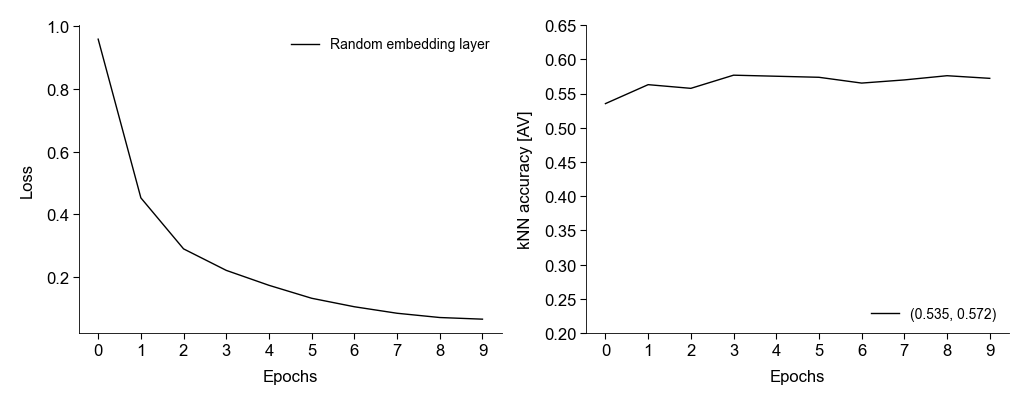

In [38]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")
model_name = "random_bert"


# load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
losses = np.load(variables_path / saving_path / "losses_run_3_10_epochs.npy")
knn_accuracies = np.load(
    variables_path / saving_path / "knn_accuracies_run_3_10_epochs.npy"
)

# saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
# knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

# plot
color = "k"  # colormap(1)

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label="Random embedding layer",
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)
# axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
# axs[1].text(
#     -0.3,
#     knn_acc_highd[0],
#     f"{knn_acc_highd[0]:.3f}",
#     fontsize=5,
#     va="center",
#     ha="left",
# )
axs[1].set_xticks(np.arange(n_epochs))
axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")

# axs[1, 0].plot(
#     np.arange(n_epochs),
#     knn_accuracies[:, 1],
#     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
#     color=color,
# )
# axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
# axs[1, 0].set_xticks(np.arange(n_epochs))
# axs[1, 0].set_ylim(0.2, 0.65)
# axs[1, 0].set_xlabel("Epochs")
# axs[1, 0].set_ylabel("kNN accuracy [CLS]")
# axs[1, 0].legend()

# axs[1, 1].plot(
#     np.arange(n_epochs),
#     knn_accuracies[:, 2],
#     label=model_name,
#     color=color,
# )
# axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
# axs[1, 1].set_xticks(np.arange(n_epochs))
# axs[1, 1].set_ylim(0.2, 0.65)
# axs[1, 1].set_xlabel("Epochs")
# axs[1, 1].set_ylabel("kNN accuracy [SEP]")

# fig.savefig(
#     figures_path
#     / "loss_and_knn_accuracy_training_embedding_layer_random_run_2_v1.png"
# )